## MB_2D_convolution_test01
baesd on MB_RF_img_plot_t_first_03
#To test whethe 2D and 1D convolution will produce the same result

#Update history: 
2020-08-24 created by ckc


In [1]:
import numpy as np
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
w, h = 660, 1500 # w - spatial dimension in units of xx mirons, 
                # h - temporal dimension (number of time steps) in units of xx ms

s = np.zeros((h, w))           # a 2D trajectory (stimulation) of a moving bar
response = np.zeros((h,w))     # response of the photo receptors


In [3]:
# generate a moving bar
width =30
#width = 30.0
speed = 0.44
contrast = 0.5
origin = int(w/3) # origin of the pulse
origin = 0.0
for i in range(h): # different time
    for j in range(w): # space
        s[i][j] = 1.
        if j -origin> speed*i and j-origin<speed*i + width:
            s[i][j] = contrast
        

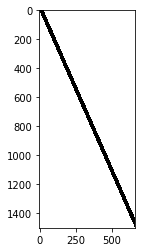

In [4]:
plt.imshow(s,cmap='gray')
plt.show()

In [5]:
# spatial filter kernel
# use of two Gussians (one inverted) to approx the receptive field

rc = 15**2
rs = 30**2
kc = 2.5
ks = 1
#ks = 0.0 # no lateral inhibition

def k_x(x):

    return kc*np.exp(-x**2/rc)-ks*np.exp(-x**2/rs)

In [6]:
# create the spatial filter array
xlen = 160 # filter length
fx = np.zeros(xlen)
for i in range(xlen):
    fx[i] = k_x((i-xlen/2))
    

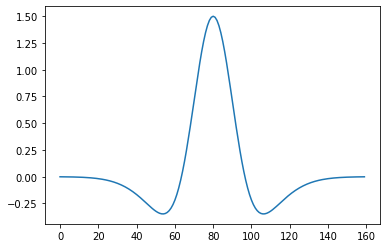

In [7]:
plt.plot(fx)

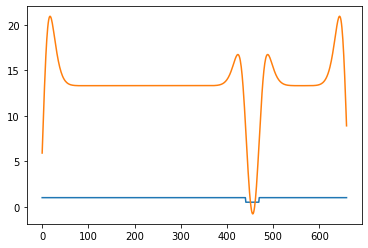

In [8]:
temp = s[1000]
r = np.convolve(temp,fx,'same')
plt.plot(temp)
plt.plot(r)

In [9]:
#k_t temporal filter
# modeling biphasic response of ganglion cell
# This is an off cell
# with a = 20/16.5 b = 0.3 c = 0.008 and t in msec
# k_t will be zero after 30 msec


rtc = 40.0**2
rts = 100.0**2
ktc = 17
kts = 6.85

def k_t(t):
    if t>0:
#        return -a*np.sin(b*t)*np.exp(-c*t*t)
        return (-ktc*np.exp(-(t-70)**2/rtc) + kts*np.exp(-(t-150)**2/rts))*10**-5
    else:
        return 0.0


In [10]:
# create temporal filter

tlen = 49
dt = 1.
ft = np.zeros(tlen)
time = np.zeros(tlen)
flag_lisa = 1

if flag_lisa > 0.5: # Lisa' filter here
    rtc = 2.0**2
    rts = 5.0**2
    ktc = 17
    kts = 6.85
    for i in range(tlen):
        if i < int(tlen/2):
            ft[i]=0.0
        else:
            t=i-int(tlen/2)
            ft[i] = (-ktc*np.exp(-(t-3)**2/rtc) + kts*np.exp(-(t-7)**2/rts))*10**-5

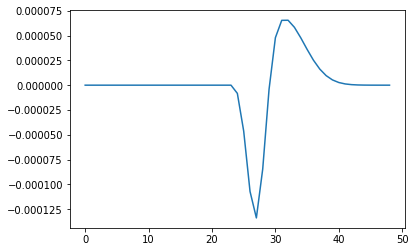

In [11]:
# display temporal filter
plt.plot(ft)
plt.show()

## Use 2D convolution to obtain response

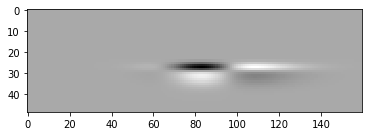

In [12]:
s_len = len(fx)
t_len = len(ft)
ksp = np.zeros((t_len, s_len))
for i in range(t_len):
    for j in range(s_len):
        ksp[i,j] = ft[i]*fx[j]*(i-j)**2
plt.imshow(ksp,cmap='gray')
plt.show()

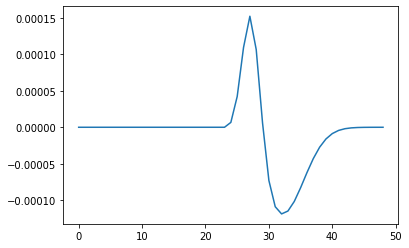

In [13]:
plt.plot(ksp[:,8])

In [14]:
import time
t0 = time.time()
r = signal.convolve2d(s,ksp,'same')
print(time.time()-t0)

16.35925841331482


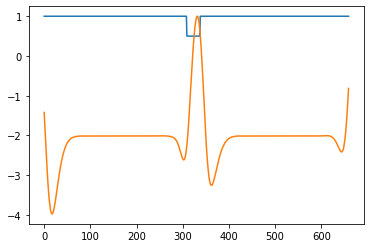

In [15]:
index = 700
plt.plot(s[index])
plt.plot(r[index]/r[index].max())

## apply convolution first in time domain and then in spatial domain

In [16]:
r2 = np.zeros((h,w)) 
t0= time.time()
for j in range(w):
    aa = s[:,j]
    r2[:,j] = np.convolve(aa,ft,"same")

for i in range(h):
    aa = r2[i,:]
    r2[i,:] = np.convolve(aa,fx,"same")
print(time.time()-t0)

0.07878899574279785


## Note that there is already anticipation after convolution with 2D kernel

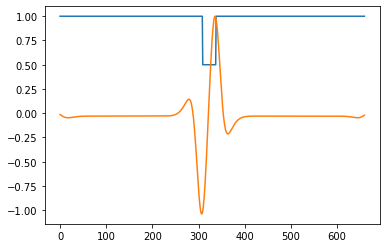

In [17]:
index = 700
plt.plot(s[index])
plt.plot(r2[index]/r2[index].max())

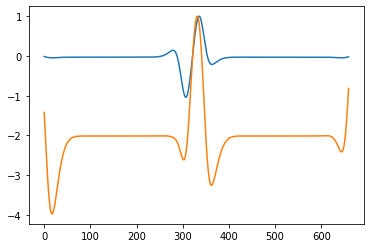

In [18]:
# compare results with different method
plt.plot(r2[index]/r2[index].max())
plt.plot(r[index]/r[index].max())

# Identical results from these two methods
much faster in r2 computation because there is no computation of off-diagonal elements

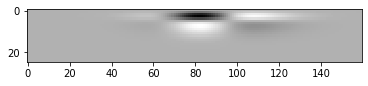

In [19]:
s_len = len(fx)
t_len = int((len(ft)+1)/2)
k2sp = np.zeros((t_len, s_len))
for i in range(t_len):
    for j in range(s_len):
        k2sp[i,j] = ft[int((len(ft))/2)+i]*fx[j]*(i-j)**2
plt.imshow(k2sp,cmap='gray')
plt.show()

## Leo's method

In [22]:
t0 = time.time()
nstep = h
mb_y = np.zeros([nstep, w])
for i in range(nstep):
    for ii in np.arange(i-np.shape(k2sp)[0]+1,i+1):
        mb_y[i,:] += np.convolve(s[ii,:],k2sp[i-ii, :], 'same')
print(time.time()-t0)

1.0701375007629395


In [ ]:
t0 = time.time()
nstep = h
mb_y2 = np.zeros([nstep, w])
for i in range(nstep):
    for ii in np.arange(i-np.shape(k2sp)[0]+1,i+1):
        for j in range(w):
            for jj in np.arange(max(0,(j-int(np.shape(k2sp)[1]/2+0.5)+1)),min(w,(j+int(np.shape(k2sp)[1]/2+0.5)+1))):
                mb_y2[i,j] += s[ii,jj]*k2sp[i-ii, j-jj+int(np.shape(k2sp)[1]/2+0.5)]
print(time.time()-t0)

In [ ]:
jj = j-int(np.shape(k2sp)[1]/2)+1
j-jj+int(np.shape(k2sp)[1]/2), k2sp[0, j-jj+int(np.shape(k2sp)[1]/2)]

In [ ]:
# comparison with Leo's method with the other two methods
plt.plot(r[index]/r[index].max())
plt.plot(r2[index]/r2[index].max())
plt.plot(mb_y[index]/mb_y[index].max())

## Conclusion:
## Leo's method does not produce the same result as the other two methods
## Computation time: 22 sec(2D): 2.88 sec (Leo's) : 0.12 sec (1D + 1D)
## much more computation in 2D; off diagonal elements

In [ ]:
a = np.array([1, 2])
b = np.array([3,4,5,6])
np.correlate(b,a,'same')